# <center> Trabalho 04 - Introdução ao Processamento de Imagem Digital </center>

**Aluno(a):** Marianna de Pinho Severo <br>
**RA:** 264960 <br>
**Professor:** Hélio Pedrini

### Passo 01: Importar bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

#### PBM
http://netpbm.sourceforge.net/doc/pbm.html

#### Morphological operations
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

#### Connected components
https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python

### Passo 02: Definir funções auxiliares

In [2]:
def print_image(image, color=0):
    
    plt.figure(figsize=(10,10))
    
    if not color:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [3]:
def imshow_components(labels): #Refereciar stack overflow
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    print_image(labeled_img)
#     cv.imshow('labeled.png', labeled_img)
#     cv.waitKey()

In [4]:
def imshow_components_rectagles(labels, stats): #Refereciar stack overflow
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    for stat in stats:
        cv.rectangle(labeled_img, (stat[0], stat[1]), (stat[0]+stat[2], stat[1]+stat[3]), (255, 255, 255), 3) 
    
    
    print_image(labeled_img)
#     cv.imshow('labeled.png', labeled_img)
#     cv.waitKey()

In [5]:
def getBlackPixelsRate(image,stat,color=1): #Black is considered 1 and White is considered 0
    init_x = stat[0]
    init_y = stat[1]
    dx = stat[2]
    dy = stat[3]
    
    area = (dx)*(dy)
    
    aux_image = image[init_y: init_y+dy,init_x:init_x + dx]
    aux_image = aux_image[aux_image == color]
    
    return len(aux_image)/area, len(aux_image), area

In [6]:
def getTransitionsRate(image, stat, total_black): #Black is 1 and White is 0
    
    if total_black == 0:
        return 0,0,0,0
    
    init_x = stat[0]
    init_y = stat[1]
    dx = stat[2]
    dy = stat[3]
    
    hor_count = 0
    ver_count = 0
    
    max_y = init_y+dy
    max_x = init_x+dx
    
    for line in range(init_y, max_y):
        for col in range(init_x, max_x):
            north = line - 1
            south = line + 1
            west = col - 1
            east = col + 1
            
            #left neighbor
            if west >= 0 and (image[line, col] == 0 and image[line,west] == 1):
                hor_count+=1
                
            # right neighbor
            if east < max_x and (image[line, col] == 0 and image[line,east] == 1):
                hor_count+=1
                
            #top neighbor
            if north >= 0 and (image[line,col] == 0 and image[north, col] == 1):
                ver_count+=1
                
            #bottom neighbor
            if south < max_y and (image[line,col] == 0 and image[south, col] == 1):
                ver_count+=1
            
    return (hor_count + ver_count)/total_black, hor_count, ver_count,total_black

### Passo 03: Ler imagem

A imagem que vamos usar neste projeto é do tipo *Portable Bitmap* (PBM). Dessa maneira, esperamos que os pixels do objeto (pixels pretos) sejam representados por valores iguais a 1 e os pixels do fundo (brancos) por valores iguais a 0.

Quando lemos essa imagem utilizando o método **imread** do *opencv*, a imagem é lida no formato monocromático, o que significa que seus valores poderão apresentar valores no intervalo de 0 a 255. Como na imagem lida só existem dois valores diferentes de pixels (0 e 255) e os valores 0 são atribuídos aos objetos, enquanto os valores 255 são atribuídos ao fundo, faremos a negação dessa imagem e dividiremos as intensidades de seus pixels por 255, de maneira a obtermos um arranjo de pixels como o esperado para uma imagem do tipo PBM. 

In [7]:
image = cv.imread('input_images/bitmap.pbm',0)
image = cv.bitwise_not(image)//255
image.shape

(1374, 2233)

### Passo 04: Criar elementos estruturantes

#### a) Elemento estruturante de 1 x 100

In [50]:
kernel1_30 = np.ones((1,50),np.uint8)
kernel1_30

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]], dtype=uint8)

#### b) Elemento estruturante de 200 x 1

In [51]:
kernel50_1 = np.ones((50,1), np.uint8)

#### c) Elemento estruturante de 1 x 30

In [52]:
kernel1_10 = np.ones((1,12), np.uint8)
kernel1_10

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [53]:
kernel1_5 = np.ones((2,1), np.uint8)
kernel1_5

array([[1],
       [1]], dtype=uint8)

### Passo 05: Aplicar etapas indicadas na descrição do trabalho

#### Etapa 01: Aplicar dilatação na imagem original com elemento estruturante de 1 x 100

In [54]:
image_p1 = cv.dilate(np.copy(image),kernel1_30)

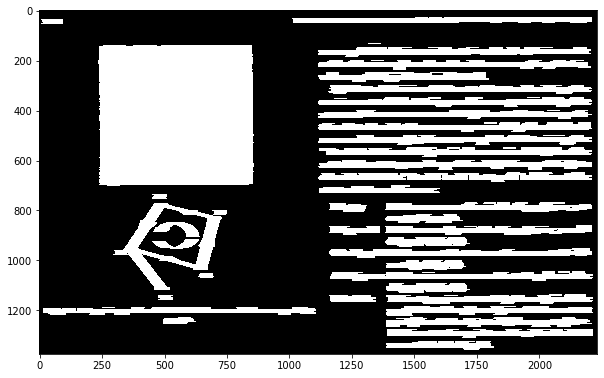

In [55]:
print_image(image_p1)

#### Etapa 02: Aplicar erosão na imagem da etapa 1 com elemento estruturante de 1 x 100

In [56]:
image_p2 = cv.erode(np.copy(image_p1),kernel1_30)

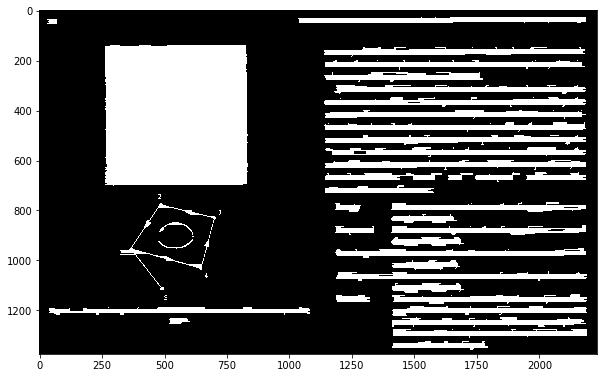

In [57]:
print_image(image_p2)

#### Etapa 03: Aplicar dilatação na imagem original com elemento estruturante de 200 x 1

In [58]:
image_p3 = cv.dilate(np.copy(image),kernel50_1)

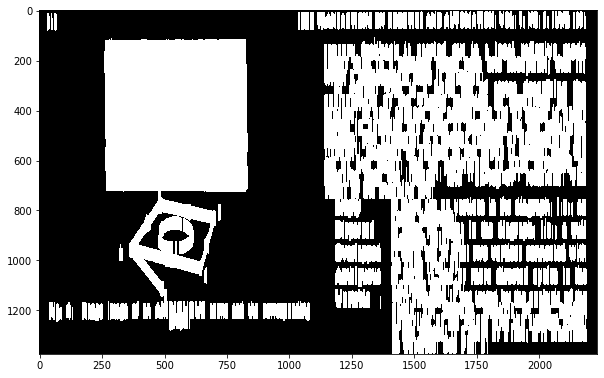

In [59]:
print_image(image_p3)

#### Etapa 04: Aplicar erosão na imagem da etapa 3 com elemento estruturante de 200 x 1

In [60]:
image_p4 = cv.erode(np.copy(image_p3),kernel50_1)

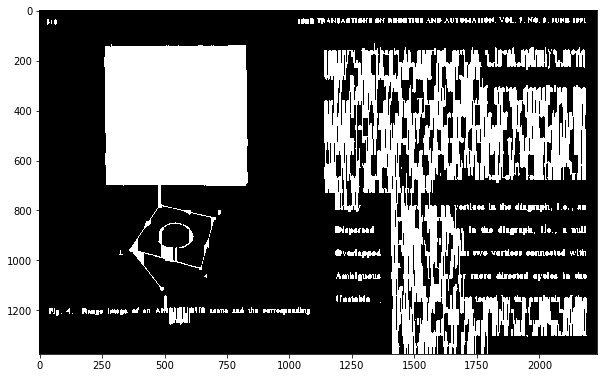

In [61]:
print_image(image_p4)

#### Etapa 05: Fazer intersecção das imagens produzidas nas etapas 2 e 4

In [62]:
image_p5 = cv.bitwise_and(image_p2, image_p4)

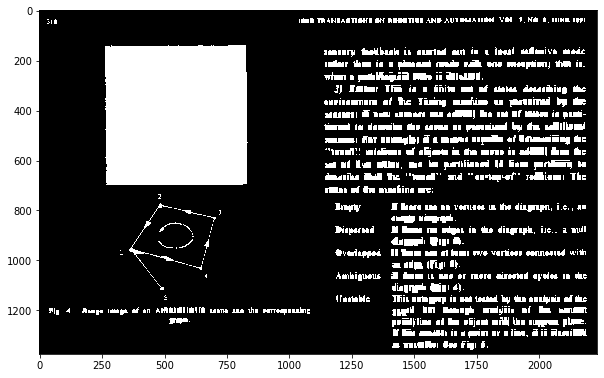

In [63]:
print_image(image_p5)

#### Etapa 06: Aplicar fechamento na imagem da etapa 5 com elemento estruturante de 1 x 30

In [64]:
image_p6 = cv.morphologyEx(image_p5, cv.MORPH_CLOSE, kernel1_10)

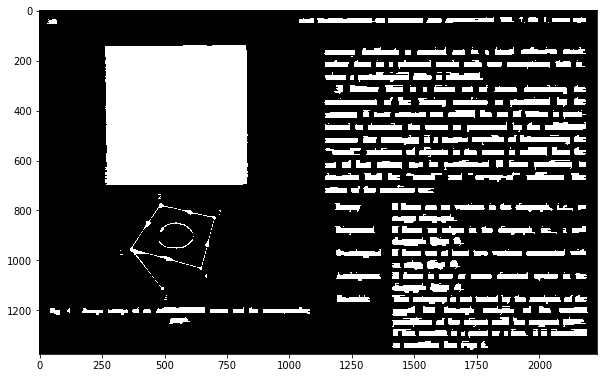

In [65]:
print_image(image_p6)

In [66]:
image_p6 = cv.morphologyEx(image_p6, cv.MORPH_OPEN, kernel1_5)

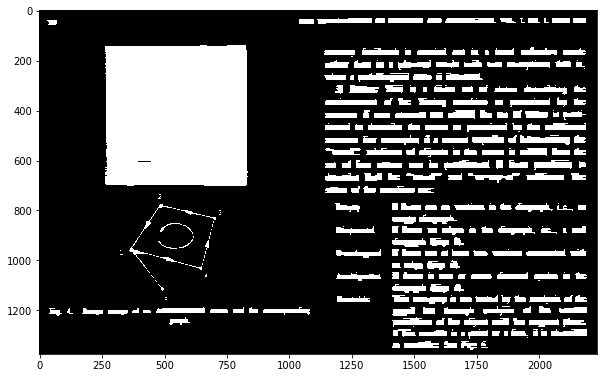

In [67]:
print_image(image_p6)

#### Etapa 07: Identificação de componentes conexos na imagem da etapa 06

In [68]:
number_of_labels, image_labels, stats, centroids = cv.connectedComponentsWithStats(image_p6)

In [69]:
print(number_of_labels)

288


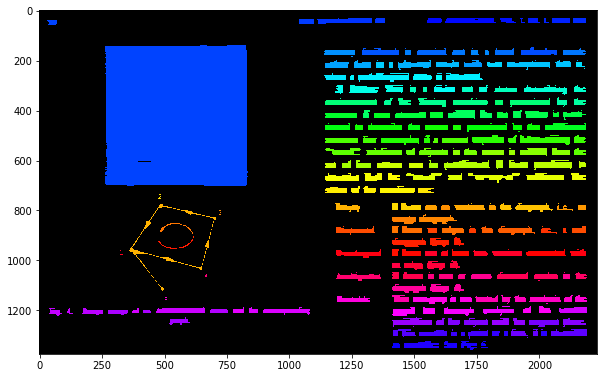

In [70]:
imshow_components(np.copy(image_labels))

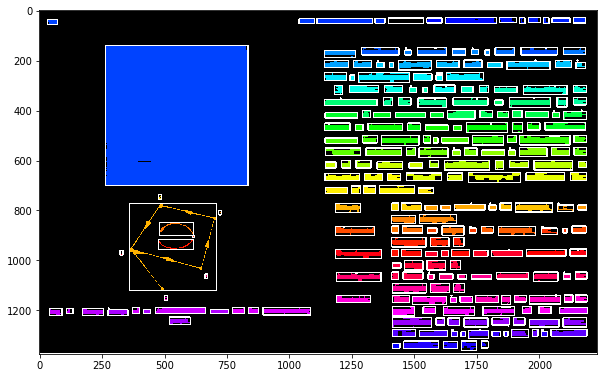

In [71]:
imshow_components_rectagles(np.copy(image_labels),stats)

#### Etapa 8: calcular razões para os componentes conexos obtidos na etapa 7

##### a) Calcular razão entre o número de pixels pretos e o número total de pixels, para cada retângulo envolvendo um componente conexo

In [72]:
black_pixels_ratios={}
black_pixels_amount = {}
component_area = {}

In [73]:
for label, stat in zip(range(number_of_labels),stats):
    black_pixels_ratios[label], black_pixels_amount[label], component_area[label] = getBlackPixelsRate(np.copy(image_p6),stat)

In [74]:
for label in black_pixels_ratios:
    print('Componente:{} | Ratio:{} | Blacks:{} | Area:{}'.format(label,black_pixels_ratios[label], black_pixels_amount[label], component_area[label]))

Componente:0 | Ratio:0.2287645095957097 | Blacks:701882 | Area:3068142
Componente:1 | Ratio:0.9375211077338736 | Blacks:2776 | Area:2961
Componente:2 | Ratio:0.8737704918032787 | Blacks:1066 | Area:1220
Componente:3 | Ratio:0.740650406504065 | Blacks:3644 | Area:4920
Componente:4 | Ratio:0.7204545454545455 | Blacks:951 | Area:1320
Componente:5 | Ratio:0.35912698412698413 | Blacks:181 | Area:504
Componente:6 | Ratio:0.8447916666666667 | Blacks:811 | Area:960
Componente:7 | Ratio:0.48412698412698413 | Blacks:244 | Area:504
Componente:8 | Ratio:0.9641812865497076 | Blacks:1319 | Area:1368
Componente:9 | Ratio:0.9203109815354713 | Blacks:947 | Area:1029
Componente:10 | Ratio:0.8993751346692523 | Blacks:4174 | Area:4641
Componente:11 | Ratio:0.9 | Blacks:720 | Area:800
Componente:12 | Ratio:0.9262295081967213 | Blacks:1130 | Area:1220
Componente:13 | Ratio:0.85 | Blacks:697 | Area:820
Componente:14 | Ratio:0.9807886217693573 | Blacks:314177 | Area:320331
Componente:15 | Ratio:0.677471264367

In [75]:
# np.sort(list(black_pixels_ratios.values()))

##### b) Razão entre o número de transições de branco para preto e o número de pixels pretos, para cada retângulo envolvendo um componente conexo

In [76]:
transition_ratios={}
hor_tran_amount = {}
ver_tran_amount = {}
total_black_amount = {}

In [77]:
for label, stat in zip(range(number_of_labels),stats):
    transition_ratios[label], hor_tran_amount[label], ver_tran_amount[label], total_black_amount[label] = getTransitionsRate(np.copy(image_p6), stat, black_pixels_amount[label])

In [78]:
for label in transition_ratios:
    print('Componente:{} | Ratio:{} | Horizontal:{}, Vertical:{} | Blacks:{}'.format(label,transition_ratios[label], hor_tran_amount[label], ver_tran_amount[label], total_black_amount[label]))

Componente:0 | Ratio:0.08966749396622224 | Horizontal:17968, Vertical:44968 | Blacks:701882
Componente:1 | Ratio:0.05511527377521614 | Horizontal:10, Vertical:143 | Blacks:2776
Componente:2 | Ratio:0.08630393996247655 | Horizontal:31, Vertical:61 | Blacks:1066
Componente:3 | Ratio:0.13336992316136115 | Horizontal:55, Vertical:431 | Blacks:3644
Componente:4 | Ratio:0.08412197686645637 | Horizontal:40, Vertical:40 | Blacks:951
Componente:5 | Ratio:0.44751381215469616 | Horizontal:41, Vertical:40 | Blacks:181
Componente:6 | Ratio:0.0468557336621455 | Horizontal:19, Vertical:19 | Blacks:811
Componente:7 | Ratio:0.2786885245901639 | Horizontal:28, Vertical:40 | Blacks:244
Componente:8 | Ratio:0.028051554207733132 | Horizontal:32, Vertical:5 | Blacks:1319
Componente:9 | Ratio:0.0908130939809926 | Horizontal:8, Vertical:78 | Blacks:947
Componente:10 | Ratio:0.08696693818878773 | Horizontal:49, Vertical:314 | Blacks:4174
Componente:11 | Ratio:0.10138888888888889 | Horizontal:32, Vertical:41 | 

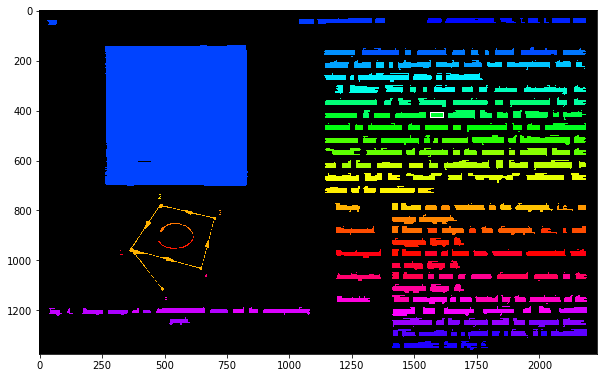

In [86]:
imshow_components_rectagles(image_labels, stats[87:88])

In [ ]:
# for key in transition_ratios:
#     if transition_ratios[key] < 0.008 and transition_ratios[key] > 0 :
#         break

In [80]:
np.sort(list(transition_ratios.values()))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00608828, 0.00660793,
       0.00736648, 0.00825013, 0.00838574, 0.01637514, 0.02010724,
       0.02556391, 0.02805155, 0.02967084, 0.02975856, 0.03273322,
       0.03541315, 0.03546099, 0.03777336, 0.0387931 , 0.03911205,
       0.03924915, 0.04149856, 0.04328224, 0.04336947, 0.0441989 ,
       0.04549284, 0.04591837, 0.04608295, 0.04634018, 0.04685573,
       0.04691358, 0.04693141, 0.04898447, 0.05014925, 0.05032406,
       0.05058366, 0.05096953, 0.05129959, 0.05140187, 0.05306748,
       0.05311921, 0.05469995, 0.05511527, 0.05690575, 0.0576087 ,
       0.05769231, 0.05797101, 0.05882353, 0.05892548, 0.05901639,
       0.06060606, 0.06073826, 0.06106409, 0.06128585, 0.06197479,
       0.06318825, 0.06432749, 0.06451613, 0.06463527, 0.0648016 ,
       0.06550992, 0.06560636, 0.06569106, 0.06592   , 0.06680441,
       0.06804598, 0.06813996, 0.06819518, 0.06884058, 0.06896

#### Etapa 9: Criar uma regra, baseada na Etapa 8, para determinar se um componente conexo é texto ou não

In [ ]:
component_classes = {}

In [ ]:
for comp_key in range(number_of_labels):
    if black_pixels_ratios[comp_key] < 0.06:
        component_classes[comp_key] = 0
    elif transition_ratios[comp_key] < 0.01 and component_area[comp_key] < 5:
        component_classes[comp_key] = 0
    elif component_area[comp_key] < 5:
        component_classes[comp_key] = 0
    else:
        component_classes[comp_key] = 1

In [ ]:
for key in component_classes:
    print("Componente:{} | Text: {}".format(key,component_classes[key]))

In [ ]:
text_labels = [key for key in component_classes if component_classes[key] == 1]
no_text_labels = [key for key in component_classes if component_classes[key] == 0]
text_stats = stats[text_labels]

text_image = np.copy(image_labels)
for l in no_text_labels:
    text_image[text_image == l] = 0

In [ ]:
imshow_components_rectagles(text_image, text_stats)

#### Etapa 10: Segmentar palavras, colocar retângulos e calcular quantidades 

##### a) Segmentar palavras

In [ ]:
np.unique(text_image)
text_image = np.uint8(text_image)
teste_i = cv.bitwise_and(image,text_image)

In [ ]:
image_10 = cv.morphologyEx(text_image, cv.MORPH_OPEN, kernel1_30)

In [ ]:
print_image(image_10)